# Couple channel model

In this notebook we will create a simple ocean-atmosphere system in a 1D channel. The two media are coupled through heat fluxes, but there is no exchange of momentum (could be added) as both are advected with pre-determined velocities. The governing equations for the atmospheric and the oceaning temperatures are

\begin{equation}
\frac{\partial T_a}{\partial t} = -u_a \frac{\partial T_a}{\partial x} + D_a\frac{\partial^2 T_a}{\partial x^2} +  \frac{F}{H_a \cdot C_{pa} \cdot \rho_a} - \frac{\alpha \epsilon T_a^4}{H_a \cdot C_{pa} \cdot \rho_a}
\end{equation}

\begin{equation}
\frac{\partial T_o}{\partial t}  = -u_o \frac{\partial T_o}{\partial x} + D_o\frac{\partial^2 T_o}{\partial x^2} - \frac{F}{H \cdot C_{po} \cdot \rho_o} + \frac{T_{AW}-T_o}{\tau} + \frac{F_{SW}}{H \cdot C_{po} \cdot \rho_o}
\end{equation}

and they are coupled through net heat flux term $F$

\begin{equation}
F=F_0+r_a \cdot C_{pa} \cdot v_a \cdot C_s \cdot (T_o-T_a)
\end{equation}

where $F_0$ is forcing term which is used to drive the model. This system lacks the latent heat flux which is why $C_s$ is taken to be 3E-3 i.e. three times higher than the conventional value 1E-3.

At the boundary we take the ocean and atmospheric temperatures to be in an equilibrium, there is no advection or diffusion, but the boundary temperature feels the radiative fluxes and is restored to 20C on an annual timescale.

## Load packages

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, LogNorm, SymLogNorm, from_levels_and_colors
from scipy import signal
import coupled_channel.cutils as cutils
from coupled_channel.surrogates import Surrogates

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define model parameters

In [50]:
#
T0   = 273.15+10 #boundary or ambient temperature
# combination of 50E3 grid cells and 40 grid cells will give 2000 km domain
xx   = 50.E3 # grid size
nx   = 40    # number of grid cells
dt   = 3600. # one hour time step is convenient
avep = 30*24*3600 #output frequency in seconds
#
spatial_pattern=100.*np.ones(nx) #scaling for the heat flux forcing (pattern will be uniform)
#spatial_pattern = 5.*np.sin(np.arange(nx)*np.pi/(nx/2.)) #NAO like pattern
#
dT = 0.
period = 2*360*24*3600.
#
SW0 = 160.-1.*np.arange(nx)
SW_anom = 160.
#
Cs = 3.E-3 # exchange coefficient for bulk formula
va = 5.    # atmospheric advection
Da = 1.E5  # atmospheric diffusion
vo = 0.05  # ocean advection
Do = 1.E2  # oceanic diffusion
Hb = 1.E3  # boundary layer height in the atmosphere [m]
H  = 100   # ocean mixed layer thickness [m]
#
tau_entrainment = 10*360*24*3600.
#

## EXAMPLE - CONTROL CLIMATE BALANCED BY ENTRAINMENT

As an example, we run the model for 10 years with constant shortwave forcing (12 month sine) and 4 year restoring time scale to ambient water which balances the net cooling by longwave radiation.

In [51]:
# set total run time to 10 years
tmax = 10*360*24*3600
#
args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':vo,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
#
# set the arguments
C         = cutils.set_model_constants(**args)
forcing   = None # no additional heat flux forcing
dt_f      = 0    # forcing time step is 0
ice_model = True # ice model will be used
atm_adv   = True # atmosphere will be advective


In [52]:
%time tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Year  1.0 277.76455570075575 277.5934289167396
Year  2.0 275.1509370008043 273.54686114147654
Year  3.0 274.431800879924 272.34958586033343
Year  4.0 274.23337048632203 272.0194145920762
Year  5.0 274.1785753412711 271.9282564459636
Year  6.0 274.16344081661987 271.9030799273668
Year  7.0 274.1592603851238 271.8961258148576
Year  8.0 274.1581056549501 271.89420493061095
Year  9.0 274.1577866908021 271.89367434225056
Year  10.0 274.1576985851532 271.8935277815384
CPU times: user 16.3 s, sys: 12 ms, total: 16.3 s
Wall time: 16.3 s


In [35]:
#%time tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt12, nt2, atm_DA_tendencies2, ocn_DA_tendencies2 = cutils.CoupledChannel2(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Text(0.5, 0, 'Time [month]')

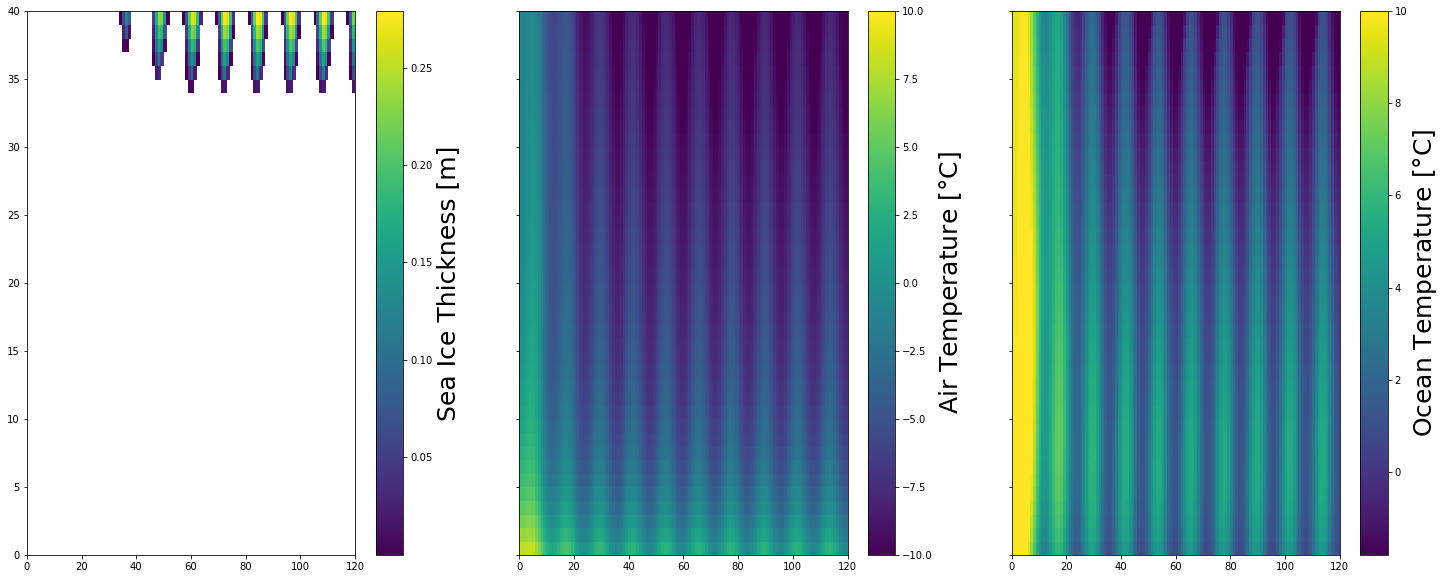

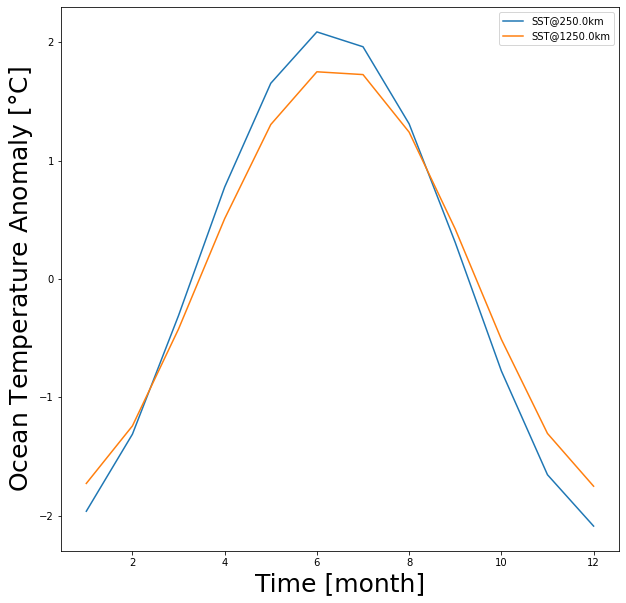

In [53]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-20,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,5]-np.nanmean(sst_out[-360*24*3600//C['avep']:,5]),label='SST@'+str(C['xx']*5/1E3)+'km')
ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,25]-np.nanmean(sst_out[-360*24*3600//C['avep']:,25]),label='SST@'+str(C['xx']*25/1E3)+'km')
ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## EXAMPLE - CONTROL CLIMATE BALANCED BY BOUNDARY CONDITIONS

As an example, we run the model for 10 years with constant shortwave forcing (12 month sine) and constant inflow temperatures which balance the net cooling by longwave radiation.

In [150]:
# set total run time to 10 years
tmax = 10*360*24*3600
tau_entrainment = 0
T0= 273.15+5
dT = 0
va = 5.    # atmospheric advection
Da = 1.E5  # atmospheric diffusion
vo = 0.05  # ocean advection
Do = 1.E2  # oceanic diffusion
#
emissivity=0.99
#
SW0 = 160.-4*np.arange(nx)
SW_anom = 160.
#
args = {'emissivity':emissivity,'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':vo,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
#
# set the arguments
C         = cutils.set_model_constants(**args)
forcing   = None # no additional heat flux forcing
dt_f      = 0    # forcing time step is 0
ice_model = True # ice model will be used
atm_adv   = True # atmosphere will be advective
#
# if dT==0 the boundary temperature will be constant, otherwise a sine curve
sst_boundary=C['T0']-C['dT']*np.cos(2*np.pi*(np.arange(0,C['tmax'],C['dt']))/(360*24*3600))
sst_boundary=C['T0']-C['dT']*np.cos(2*np.pi*(np.arange(0,C['tmax'],C['dt']))/(5*360*24*3600))
#
%time tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f,sst_boundary=sst_boundary, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Year  1.0 276.74320295303335 274.6104442820586
Year  2.0 276.7432012020573 274.50722552328904
Year  3.0 276.7432012020573 274.50722524578754
Year  4.0 276.7432012020573 274.50722524578754
Year  5.0 276.7432012020573 274.50722524578754
Year  6.0 276.7432012020573 274.50722524578754
Year  7.0 276.7432012020573 274.50722524578754
Year  8.0 276.7432012020573 274.50722524578754
Year  9.0 276.7432012020573 274.50722524578754
Year  10.0 276.7432012020573 274.50722524578754
CPU times: user 16.1 s, sys: 60 ms, total: 16.1 s
Wall time: 16.2 s


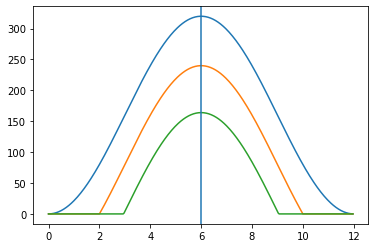

In [151]:
# This is what the shortwave pattern looks like
plt.plot(np.arange(0,12,1/30),np.max(np.concatenate([(C['SW0'][0]-C['SW_anom']*np.cos(2*np.pi*(np.arange(0,360*24*3600,1*24*3600))/(360*24*3600)))[np.newaxis,],np.zeros((1,360))],axis=0),0))
plt.plot(np.arange(0,12,1/30),np.max(np.concatenate([(C['SW0'][20]-C['SW_anom']*np.cos(2*np.pi*(np.arange(0,360*24*3600,1*24*3600))/(360*24*3600)))[np.newaxis,],np.zeros((1,360))],axis=0),0))
plt.plot(np.arange(0,12,1/30),np.max(np.concatenate([(C['SW0'][-1]-C['SW_anom']*np.cos(2*np.pi*(np.arange(0,360*24*3600,1*24*3600))/(360*24*3600)))[np.newaxis,],np.zeros((1,360))],axis=0),0))
plt.axvline(x=360/30/2)

Text(0.5, 0, 'Time [month]')

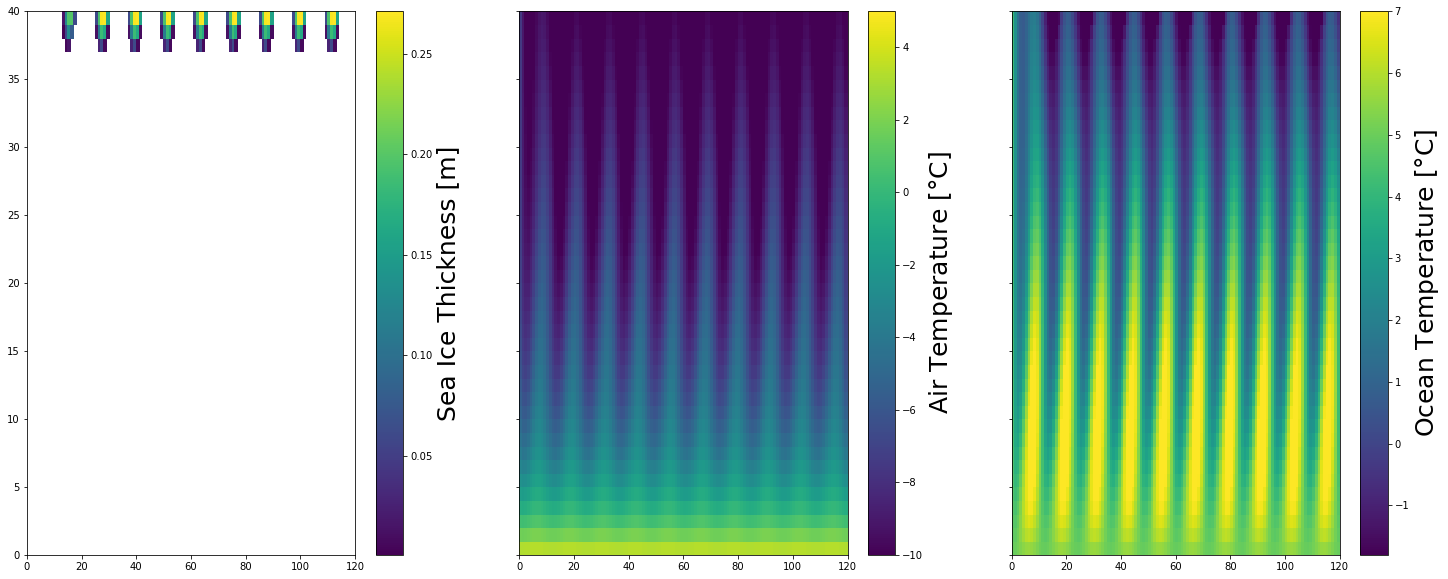

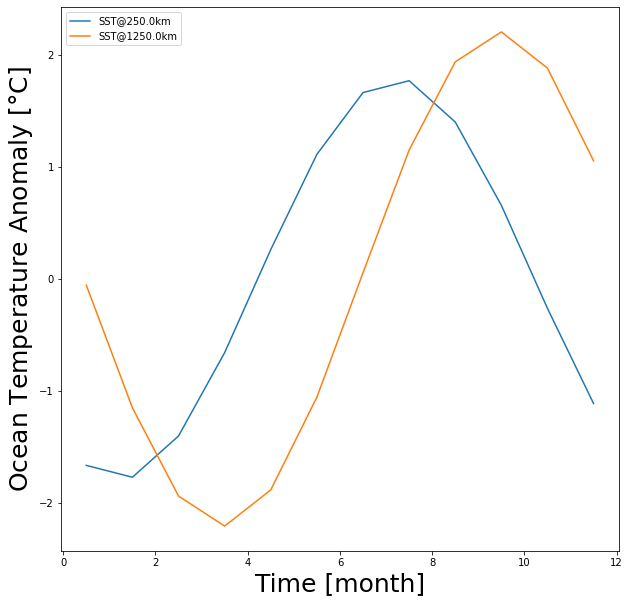

In [152]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-15,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+2)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
ax4.plot(np.arange(1,13)-0.5,sst_out[-360*24*3600//C['avep']:,5]-np.nanmean(sst_out[-360*24*3600//C['avep']:,5]),label='SST@'+str(C['xx']*5/1E3)+'km')
ax4.plot(np.arange(1,13)-0.5,sst_out[-360*24*3600//C['avep']:,25]-np.nanmean(sst_out[-360*24*3600//C['avep']:,25]),label='SST@'+str(C['xx']*25/1E3)+'km')
ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## EXERCISE 1 - SLAB OCEAN

Show that by diagnosing the fluxes from a fully coupled simulation you can replicate the same control climate.

In [154]:
# 
#H=50
#va=5
#args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
# first run a control case for 10 years without any time-variable forcing
tmax=20*360*24*3600
args['tmax']=tmax
C['dT'] = 0.0
C    = cutils.set_model_constants(**args)
forcing = None
#
sst_boundary=C['T0']-C['dT']*np.cos(2*np.pi*(np.arange(0,C['tmax'],C['dt']))/(360*24*3600))
#
tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, sst_boundary=sst_boundary, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)


Year  1.0 276.74320295303335 274.6104442820586
Year  2.0 276.7432012020573 274.50722552328904
Year  3.0 276.7432012020573 274.50722524578754
Year  4.0 276.7432012020573 274.50722524578754
Year  5.0 276.7432012020573 274.50722524578754
Year  6.0 276.7432012020573 274.50722524578754
Year  7.0 276.7432012020573 274.50722524578754
Year  8.0 276.7432012020573 274.50722524578754
Year  9.0 276.7432012020573 274.50722524578754
Year  10.0 276.7432012020573 274.50722524578754
Year  11.0 276.7432012020573 274.50722524578754
Year  12.0 276.7432012020573 274.50722524578754
Year  13.0 276.7432012020573 274.50722524578754
Year  14.0 276.7432012020573 274.50722524578754
Year  15.0 276.7432012020573 274.50722524578754
Year  16.0 276.7432012020573 274.50722524578754
Year  17.0 276.7432012020573 274.50722524578754
Year  18.0 276.7432012020573 274.50722524578754
Year  19.0 276.7432012020573 274.50722524578754
Year  20.0 276.7432012020573 274.50722524578754


In [156]:
# then run a case without ocean advection, but input the DA tendencies using the last 10 years of the previous case 
atm_DA_tendencies2 = atm_DA_tendencies[-int(360*24*3600//C['dt']):]
ocn_DA_tendencies2 = ocn_DA_tendencies[-int(360*24*3600//C['dt']):]
#
tmax=20*360*24*3600
args['tmax']=tmax
args['vo']=0.0
C    = cutils.set_model_constants(**args)
tas_out_slab, sst_out_slab, hice_out_slab, sflx_out_slab, sflx_f_out_slab, nt1, nt = cutils.CoupledChannel(C,forcing, dt_f=dt_f, sst_boundary=sst_boundary, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2,atm_DA_tendencies=atm_DA_tendencies2)
#

Year  1.0 277.832505647639 277.3244668660164
Year  2.0 277.5694822714508 276.66696997242735
Year  3.0 277.3701261905184 276.16395860436523
Year  4.0 277.2189592700302 275.77870887251737
Year  5.0 277.10429458473175 275.483401374438
Year  6.0 277.01729582912964 275.2568909773949
Year  7.0 276.95127512184087 275.08306382226755
Year  8.0 276.9011666834805 274.949615646114
Year  9.0 276.86313112470543 274.8471366881102
Year  10.0 276.83425723154335 274.7684222702593
Year  11.0 276.81233682115635 274.7079510446907
Year  12.0 276.79569453009884 274.66148873652213
Year  13.0 276.7830589972184 274.62578637145003
Year  14.0 276.77346529639135 274.5983499700004
Year  15.0 276.76618099321706 274.57726449426696
Year  16.0 276.760650079744 274.56105909591196
Year  17.0 276.7564504496592 274.54860387518073
Year  18.0 276.7532616351794 274.5390307224101
Year  19.0 276.75084032439054 274.53167258907393
Year  20.0 276.74900177987155 274.5260168767141


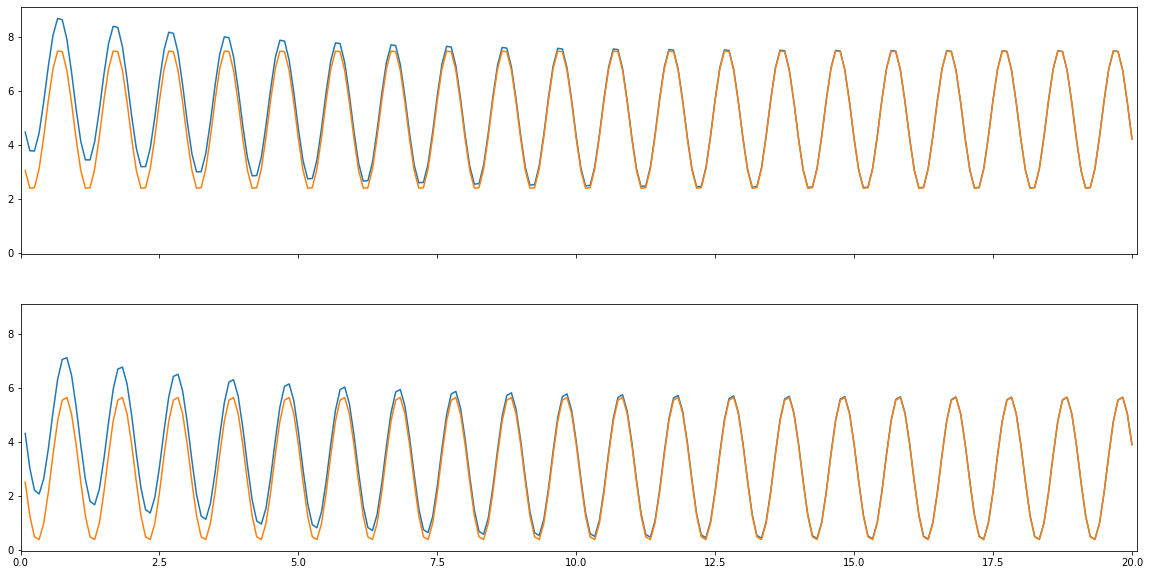

In [157]:
fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True,figsize=(20,10))
diag_points=[10,20]
timeaxis=np.arange(1/12,20,1/12)
for a,ax in enumerate(axes.flatten()):
    j=diag_points[a]
    ax.plot(timeaxis,sst_out_slab[:,j]-273.15)
    ax.plot(timeaxis,np.tile(sst_out[-360*24*3600//C['avep']:,j],20)-273.15)
    ax.set_xlim(0,20+1/12)
#

## Exercise 2 - Perturbation Study



In [ ]:
# 
tas_out0, sst_out0, hice_out0, sflx_out0, sflx_f_out0, nt1_0, nt0 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern)

## Realistic Forcing

In [ ]:
#forcings
#nao=np.loadtxt('norm.nao.monthly.b5001.current.ascii.table')[:-1,-1]; dt_f=30*24*3600 #66 years of monthly NAO
nao0 = np.loadtxt('../data/raw/norm.daily.nao.index.b500101.current.ascii')[:,-1]; dt_f=24*3600 #66 yeas of daily NAO
#
nao_surrogate    = Surrogates(np.tile(nao0[:50*360,np.newaxis],22).T)
nao_s = nao_surrogate.refined_AAFT_surrogates(np.tile(nao0[:50*360,np.newaxis],22).T,10).flatten().squeeze()
nao_s = -2*(0.5-(nao_s - np.min(nao_s,0))/np.max((nao_s - np.min(nao_s,0)),0))
#
nao_white=1-2*np.random.rand(len(nao_s))
#
tmax = (len(nao_s)-1*360.)*dt_f
#
forcing = nao_s #None #100*nao
forcing_str = 'synthetic_nao_random_spatial'



In [ ]:
plt.figure(figsize=(20,5))
#
plt.plot(nao_white)
plt.plot(nao_s)
#
plt.figure()
f0,p0 = signal.welch(-2*(0.5-(nao0 - np.min(nao0,0))/np.max((nao0 - np.min(nao0,0)),0)),fs=1,nperseg=20*360)
f1,p1 = signal.welch(nao_s,fs=1,nperseg=20*360)
f2,p2 = signal.welch(nao_white,fs=1,nperseg=20*360)
plt.loglog(f0,p0)
plt.loglog(f1,p1)
plt.loglog(f2,p2)
plt.axvline(x=1/30,lw=2,ls='--',color='gray')

In [7]:
# RUN THE MODEL
data={}
for nf_str,nao in enumerate([nao_s,nao_white]):
    if nf_str==0:
        forcing_str = 'synthetic_nao_random_spatial'
    elif nf_str==1:
        forcing_str = 'white_noise_nao_random_spatial'
    #
    for H in [50]: #,100,200]:
        for va in [5]: #,10,15]:
            #print(H,va)
            #if os.path.exists('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz'):
            #    print('case exists - loading...')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz')
            #    print('done!')
            #else:
                tmax = 50*360*24*3600
                args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
                # first run a control case for 10 years without any forcing
                C    = cutils.set_model_constants(**args)
                forcing = None
                tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)
                atm_DA_tendencies2 = atm_DA_tendencies[-360*24*3600//C['dt']:]
                ocn_DA_tendencies2 = ocn_DA_tendencies[-360*24*3600//C['dt']:]
                # then run a fully coupled case with varying forcing
                forcing = nao
                tmax    = (len(nao)-1*360)*dt_f
                args['tmax'] = tmax
                C = cutils.set_model_constants(**args)
                #
                tas_out0, sst_out0, hice_out0, sflx_out0, sflx_f_out0, nt1_0, nt0 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern)
                # then run a slab ocean case (i.e. ocean advection and diffusion tendencies from the control case)
                tas_out1, sst_out1, hice_out1, sflx_out1, sflx_f_out1, nt1_1, nt1 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2)
                # then run a slab_atm (i.e. atm advection and diffusion tendencies from the control case)
                tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt1_2, nt2 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,atm_DA_tendencies=atm_DA_tendencies2)
                #Save the data
                #
                print('saving the data...')
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz',tas_out=tas_out0, sst_out=sst_out0, hice_out=hice_out0, sflx_out=sflx_out0, sflx_f_out=sflx_f_out0,nt1=nt1_0,nt=nt0,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz',tas_out=tas_out1, sst_out=sst_out1, hice_out=hice_out1, sflx_out=sflx_out1, sflx_f_out=sflx_f_out1,nt1=nt1_1,nt=nt1,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz',tas_out=tas_out2, sst_out=sst_out2, hice_out=hice_out2, sflx_out=sflx_out2, sflx_f_out=sflx_f_out2,nt1=nt1_2,nt=nt2,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                #
                #load the same data
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz')
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz')
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz')
        #

293.15 [160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143
 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 125
 124 123 122 121] 100000.0 50000.0
0.9654210260279585
293.15 294.11542102602795
Year  1.0 279.7300597948741 278.87574551433653
Year  2.0 275.55166661195165 272.8628869571969
Year  3.0 274.7019271558007 271.6107638494162
Year  4.0 274.5276917650988 271.35936239121025
Year  5.0 274.49190601084376 271.35000149386104
Year  6.0 274.48455356028126 271.3500001899152
Year  7.0 274.4830428385747 271.35000080947884
Year  8.0 274.4827324233054 271.35000096621076
Year  9.0 274.48266864059445 271.35000056873713
Year  10.0 274.48265553480974 271.35000129237085
Year  11.0 274.4826528418891 271.35000015829127
Year  12.0 274.48265228856206 271.3500007127731
Year  13.0 274.4826521748649 271.35000053263286
Year  14.0 274.4826521515046 271.35000049562024
Year  15.0 274.482652146702 271.3500004880129
Year  16.0 274.4826521457154 271.3500004864484
Year  17.